In [1]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-05-27 18:50:59.626995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 18:51:00.462662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = 'data/data-science-bowl-2018/'
TRAIN_PATH = 'data/data-science-bowl-2018/train/'
TEST_PATH = 'data/data-science-bowl-2018/test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
# Unzip data
# with zipfile.ZipFile(UNZIP_PATH + 'stage1_train.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/data-science-bowl-2018/train')
    
# with zipfile.ZipFile(UNZIP_PATH + 'stage1_test.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/data-science-bowl-2018/test')

In [4]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
#print(train_ids[0])

In [5]:
test_ids = next(os.walk(TEST_PATH))[1]
# print(test_ids)

In [6]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
#print(X_train)

In [7]:
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool_)
# print(Y_train)

# Investigate a single image

In [8]:
# id_ = train_ids[0]
# path = TRAIN_PATH + id_
# # print(path)
# # Read the image
# img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
# # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
# # Display the image
# plt.imshow(img)
# plt.title(f"Image ID: {id_}")
# plt.show()

In [9]:
# img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

In [10]:
# X_train = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# X_train[0] = img
# mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# for mask_file in next(os.walk(path + '/masks/'))[2]:
#     mask_ = imread(path + '/masks/' + mask_file)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#     mask = np.maximum(mask, mask_)
#     # plt.imshow(mask_,  cmap='gray')
#     # plt.title(f"Image ID: {mask_file}")
#     # plt.show()
# Y_train = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
# Y_train[0] = mask
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(X_train[0])
# plt.title("Processed Image")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(np.squeeze(Y_train[0]), cmap='gray')
# plt.title("Processed Mask")
# plt.axis('off')

# plt.show()

# Get groundtruths

In [12]:
# Get ground truth for x_train
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    # print(n, id_)
    # Get the path to the image and mask directories
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [02:18<00:00,  4.83it/s]


In [13]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print(len(test_ids))
# Loop through all the test_ids
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    # Get the path to the test image
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

65


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 90.72it/s]


# Training Unet

In [14]:
# Create a function for a convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

# Create a function for the expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [15]:
# Inputs
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

2024-05-27 18:54:37.662069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 18:54:37.759314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 18:54:37.759521: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'img_segmentation_mode.keras', verbose=1, save_best_only=True
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [19]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.7583 - loss: 0.5427 - val_accuracy: 0.8730 - val_loss: 0.2709
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8823 - loss: 0.2829 - val_accuracy: 0.9241 - val_loss: 0.1772
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9160 - loss: 0.2137 - val_accuracy: 0.9465 - val_loss: 0.1337
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9402 - loss: 0.1502 - val_accuracy: 0.9522 - val_loss: 0.1193
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9437 - loss: 0.1430 - val_accuracy: 0.9550 - val_loss: 0.1131
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9503 - loss: 0.1255 - val_accuracy: 0.9514 - val_loss: 0.1240
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9478 - loss: 0.1358 - val_accuracy: 0.9566 - val_loss: 0.1165
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9554 - loss: 0.1171 - val_accuracy: 0.9569 -

# Inference

In [20]:
idx = random.randint(0, len(X_train))
idx

245

In [21]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step


In [22]:
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


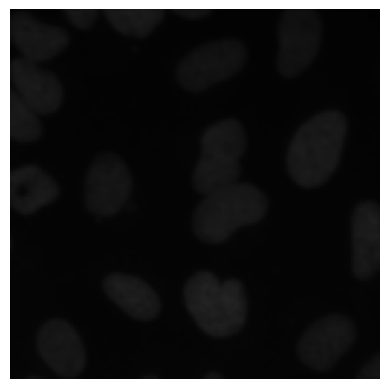

Ground Truth Mask:


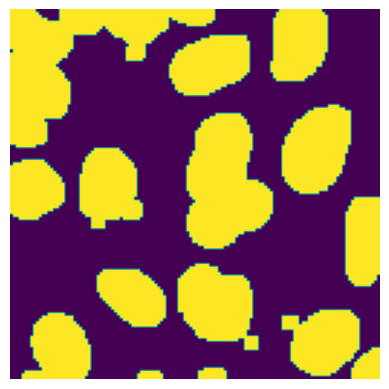

Predicted Mask:


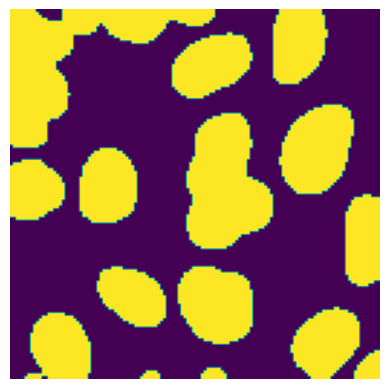

In [23]:
# Select a random index from training set
ix = random.randint(0, len(preds_train_t))

# Display the input image
print("Input Image:")
display_images(X_train[ix])

# Display the ground truth mask
print("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

# Display the predicted mask
print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

Validation Input Image:


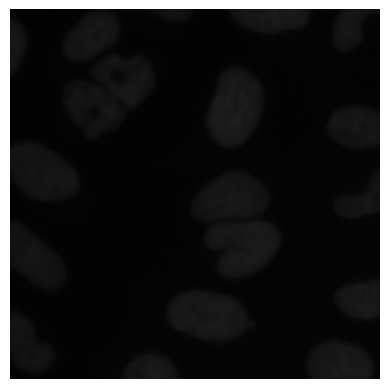

Validation Ground Truth Mask:


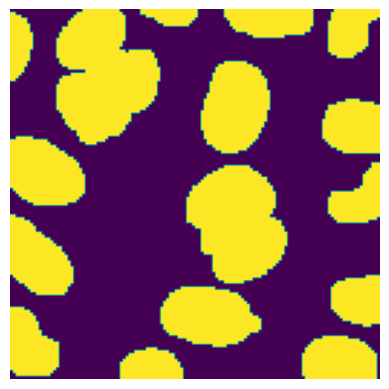

Validation Predicted Mask:


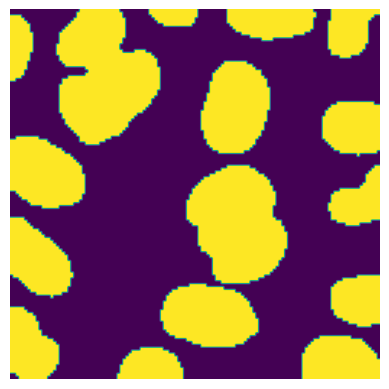

In [24]:
# Select a random index from validation set
ix = random.randint(0, len(preds_val_t))

# Calculate the index from where validation data starts
val_data_start = int(X_train.shape[0] * 0.9)

# Display the validation input image
print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

# Display the validation ground truth mask
print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

# Display the validation predicted mask
print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))
